In [1]:
import os
import math

import torch
import numpy as np
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.heat.heat_diffusion import GaussHeatDiffusion, HeatDiffusion_Revised
from scorefield.models.rrt.rrt import RRTStar
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, overlay_goal, overlay_multiple, combine_objects, overlay_images,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
    draw_obstacles_pil, convert_to_obstacle_masks,
    randgen_obstacle_masks, draw_obstacles_pixel,
    vector_field, clip_vectors,
    clear_img, clear_obs 
)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# Args
config_dir = "./scorefield/configs/heat_diffusion.yaml"

args = load_config(config_dir)
device = args['device']

bg = Image.open('assets/toy_exp/background0.png').convert('RGBA')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
# wastes.append(Image.open('assets/toy_exp/waste4.png'))
# wastes.append(Image.open('assets/toy_exp/waste5.png'))


img_size = args['image_size']
goal_bounds = args['goal_bounds']
goal_num = len(wastes)
agent_bounds = args['agent_bounds']
obstacle_pos = args['obstacles']


noise_steps = args['noise_steps']
u0 = args['u0']
min_heat_step = args['min_heat_step']
max_heat_step = args['max_heat_step']
sample_num = args['sample_num']
time_type = args['time_type']
noise_steps = args['noise_steps']

diffusion = HeatDiffusion_Revised(
    image_size=img_size,
    u0 = u0,
    noise_steps=noise_steps,
    min_heat_step=min_heat_step,
    max_heat_step=max_heat_step,
    time_type=time_type,
    device=device,
)

gauss_diffusion = GaussHeatDiffusion(
    image_size=img_size,
    u0 = u0,
    noise_steps=noise_steps,
    min_heat_step=min_heat_step,
    max_heat_step=max_heat_step,
    time_type=time_type,
    device=device,
)

def normalize_tensor(tensor):
    return (tensor - torch.min(tensor)) / (torch.max(tensor) - torch.min(tensor))

def plot_heat_on_axis(ax, heatmap, background_img, goal_data, agent_data, dot_size=5):
    norm_data = normalize_tensor(heatmap).cpu().detach().numpy()
    rgb_data = (plt.cm.hot(norm_data)[:, :, :3] * 255).astype(np.uint8)
    
    # Using broadcasting to create the RGBA image more concisely
    rgba_data = np.concatenate([rgb_data, (norm_data[..., None] * 255).astype(np.uint8)], axis=-1)
    
    heat_img = Image.fromarray(rgba_data, 'RGBA')
    heat_resized = heat_img.resize(background_img.size)
    composite_img = Image.alpha_composite(background_img, heat_resized)
    final_img = clear_img(agent_data.cpu(), goal_data.cpu(), composite_img, dot_size)
    ax.imshow(final_img[0])
    ax.axis('off')



dt:tensor([   50,   128,   288,   578,  1058,  1922,  3200,  5408,  8978, 14450],
       device='cuda:0')
heat kernel std:tensor([ 5.,  8., 12., 17., 23., 31., 32., 32., 32., 32.], device='cuda:0')
dt:tensor([   50,   128,   288,   578,  1058,  1922,  3200,  5408,  8978, 14450],
       device='cuda:0')
heat kernel std:tensor([ 5.,  8., 12., 17., 23., 31., 32., 32., 32., 32.], device='cuda:0')


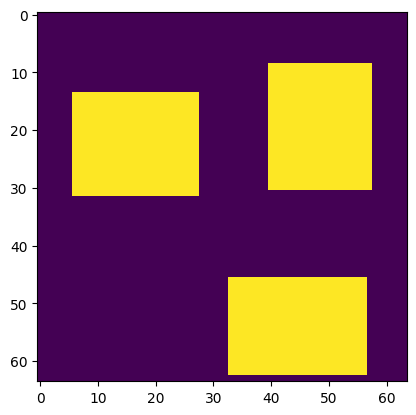

In [2]:
obstacle_masks = randgen_obstacle_masks(1, img_size, 5657)
background = draw_obstacles_pixel(bg, obstacle_masks)

obstacle_masks = obstacle_masks[0].unsqueeze(0)

plt.imshow(obstacle_masks[0].cpu().numpy())
plt.show()

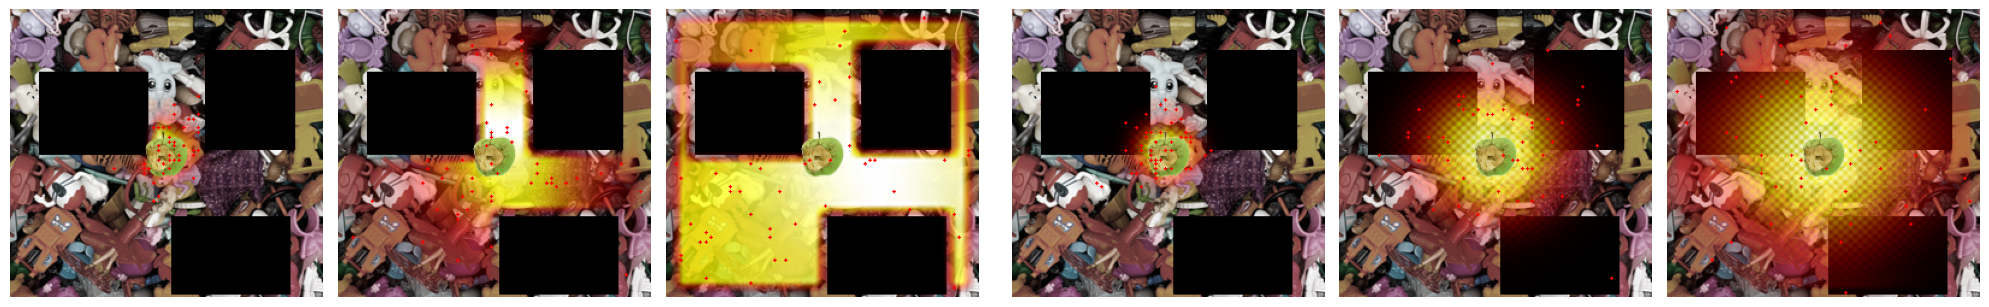

In [9]:
# Paper Figure
goal = torch.tensor([[[-0.,-0.]]], device=device)
obs = clear_obs(goal.cpu(), background[0])
t = torch.tensor([i for i in range(1, noise_steps+1)], device=device)

heat, _, _, x_t = diffusion.forward_diffusion(t, goal.repeat(10,1,1), 50, obstacle_masks.repeat(10,1,1))
heat2, x_t2 = gauss_diffusion.forward_diffusion(t, goal.repeat(10,1,1), 50)

fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 7, width_ratios=[1, 1, 1, 0.01, 1, 1, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[4])
ax4 = fig.add_subplot(gs[5])
ax5 = fig.add_subplot(gs[6])

axes = [ax0, ax1, ax2, ax3, ax4, ax5]

# Use these axes to display your images:
# axes[0].imshow(obs[0].permute(1,2,0).cpu().numpy())
axes[0].imshow(obs[0])
axes[0].axis('off')

heat_steps_1 = [0, 3, 5]
heat_steps_2 = [0, 2, 3]

for idx, step in enumerate(heat_steps_1):
    plot_heat_on_axis(axes[idx], heat[step], background[0], goal.cpu(), x_t[step].unsqueeze(0).cpu())
for idx, step in enumerate(heat_steps_2):
    plot_heat_on_axis(axes[idx+3], heat2[step], background[0], goal.cpu(), x_t2[step].unsqueeze(0).cpu())

plt.tight_layout()
plt.show()

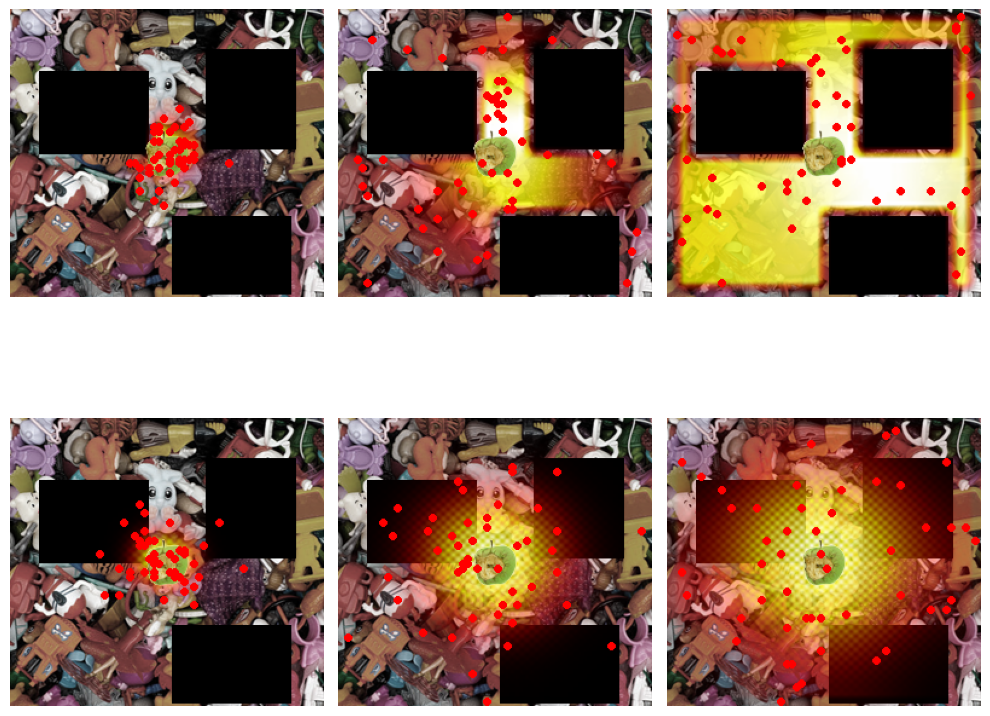

In [10]:
# Poster Figure
goal = torch.tensor([[[-0.,-0.]]], device=device)
obs = clear_obs(goal.cpu(), background[0])
t = torch.tensor([i for i in range(1, noise_steps+1)], device=device)

heat, _, _, x_t = diffusion.forward_diffusion(t, goal.repeat(10,1,1), 50, obstacle_masks.repeat(10,1,1))
heat2, x_t2 = gauss_diffusion.forward_diffusion(t, goal.repeat(10,1,1), 50)

fig = plt.figure(figsize=(10, 9))
gs = gridspec.GridSpec(2, 3)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])

axes = [ax0, ax1, ax2, ax3, ax4, ax5]

# Use these axes to display your images:
axes[0].imshow(obs[0])
axes[0].axis('off')

heat_steps_1 = [0, 3, 5]
heat_steps_2 = [0, 2, 3]

for idx, step in enumerate(heat_steps_1):
    plot_heat_on_axis(axes[idx], heat[step], background[0], goal.cpu(), x_t[step].unsqueeze(0).cpu(), 6)
for idx, step in enumerate(heat_steps_2):
    plot_heat_on_axis(axes[idx+3], heat2[step], background[0], goal.cpu(), x_t2[step].unsqueeze(0).cpu(), 6)

plt.subplots_adjust(hspace=0.5)
    
plt.tight_layout()
plt.show()